In this notebook we will be preprocessing the following raw data:
- Yellow taxi data (2018)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.getOrCreate()

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)    # make it looks good
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)   # enable spark arrow

In [ ]:
# download dataset
from os.path import getsize
from urllib.request import urlretrieve

# you will need to create the "large" folder if it does not exist
# you can also change this to change where you want the data to be downloaded
output_dir = "../raw_data"

def download_data(fname_template, start, end):
    # template for the type of taxi / year you wish to download

    # change range(x, y) to be the months you want
    for m in range(start, end):
        month = str(m).zfill(2)
        out = f'{fname_template}-{month}.csv'
        url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/{out}"
        urlretrieve(url, f"{output_dir}/{out}")

        print(f"Done downloading {out} to {output_dir} with size {getsize(f'{output_dir}/{out}') / 1073741824:.2f}GB")

        
download_data("yellow_tripdata_2018" 1, 3)
download_data("yellow_tripdata_2018" 6, 9)
download_data("yellow_tripdata_2018" 12, 13)
download_data("yellow_tripdata_2018" 2, 3)
download_data("yellow_tripdata_2018" 7, 8)
download_data("yellow_tripdata_2018" 12, 13)

In [115]:
# Load dataset
## yellow taxi 2018 (1, 2, 6, 7, 8, 12 month)

yellow_1801_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-01.csv', header=True)
yellow_1802_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-02.csv', header=True)
yellow_1806_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-06.csv', header=True)
yellow_1807_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-07.csv', header=True)
yellow_1808_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-08.csv', header=True)
yellow_1812_sdf = spark.read.csv('../raw_data/yellow_tripdata_2018-12.csv', header=True)

# merge datasets
sdf = yellow_1801_sdf.unionAll(yellow_1802_sdf).unionAll(yellow_1806_sdf).unionAll(yellow_1807_sdf).unionAll(yellow_1808_sdf).unionAll(yellow_1812_sdf)

sdf.limit(3)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,.50,1,N,41,24,2,4.5,0.5,0.5,0,0,0.3,5.8
1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.70,1,N,239,140,2,14,0.5,0.5,0,0,0.3,15.3
1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,.80,1,N,262,141,1,6,0.5,0.5,1,0,0.3,8.3


In [3]:
# raw data row count
sdf.count()

49837894

Data Preprocessing
1.  Fix the dtype issues (there are all string type by default)
2.  Extract some simple but useful features
3. Remove unwanted columns
4.  Remove outlier (mean +- 3 * stdv)

In [116]:
# change column dtypes

ints = ('VendorID', 'passenger_count', 'RateCodeID', 'RatecodeID', 'payment_type', 'trip_type', 'DOlocationID', 'DOLocationID', 'PUlocationID', 'PULocationID')
doubles = ('trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
           'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount')
strings = ('store_and_fwd_flag', 'ehail_fee', 'SR_Flag', 'Dispatching_base_num', 'Dispatching_base_number')
dtimes = ('lpep_pickup_datetime', 'lpep_dropoff_datetime', 'Pickup_DateTime', 'DropOff_datetime', 'tpep_pickup_datetime', 'tpep_dropoff_datetime')

dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: DoubleType() for column in doubles})
dtypes.update({column: StringType() for column in strings})
dtypes.update({column: TimestampType() for column in dtimes})

for column in sdf.columns:
    sdf = sdf.withColumn(column, sdf[column].cast(dtypes[column]))

In [117]:
# extract some useful features
# trip duration in minutes
sdf = sdf.withColumn('trip_duration_min', (F.col('tpep_dropoff_datetime').cast('long') - F.col('tpep_pickup_datetime').cast('long'))/60.)

# pickup day of week
sdf = sdf.withColumn('pickup_day', F.date_format('tpep_pickup_datetime', 'E'))

# pickup hour
sdf = sdf.withColumn('pickup_hour', F.date_format('tpep_pickup_datetime', 'H'))
sdf = sdf.withColumn('pickup_hour', sdf['pickup_hour'].cast(IntegerType())) # convert to int type

# total_surcharge
sdf = sdf.withColumn('total_surcharge', (F.col('extra') + F.col('mta_tax') + F.col('tolls_amount') + F.col('improvement_surcharge')))
sdf = sdf.withColumn('total_surcharge', sdf['total_surcharge'].cast(DoubleType()))  # convert to double type

# remove unwanted columns
drop_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge']
sdf = sdf.drop(*drop_cols)

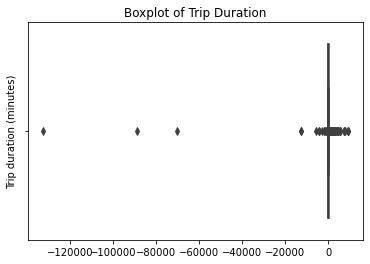

In [9]:
# We now look at the distribution of the raw data

# before preprocessing
# boxplot of trip duration
trip_duration_df = sdf.select('trip_duration_min').toPandas()
sns.boxplot(x = trip_duration_df['trip_duration_min'])
plt.title('Boxplot of Trip Duration')
plt.ylabel('Trip duration (minutes)')
plt.xlabel('')
plt.savefig('../plots/trip_duration_raw_boxplot.png')
plt.show()

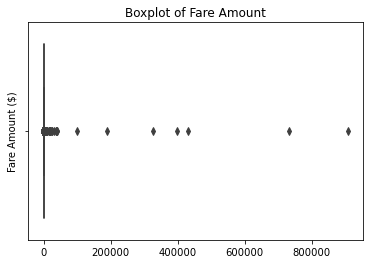

In [10]:
# before preprocessing
# boxplot of fare amount
fare_amount_df = sdf.select('fare_amount').toPandas()
sns.boxplot(x = fare_amount_df['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')
plt.savefig('../plots/fare_amount_raw_boxplot.png')
plt.show()

In [12]:
# list numeric columns to be preprocessed
yellow_num_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_duration_min', 'total_surcharge']
yellow_mean_stdv = sdf.agg( *[F.mean(colName).alias('mean_{}'.format(colName)) for colName in yellow_num_cols],
                           *[F.stddev(colName).alias('stddev_{}'.format(colName)) for colName in yellow_num_cols])

yellow_mean_std_min_max = yellow_mean_stdv

# flag mean +- 3 * stdv as outliers
for colName in yellow_num_cols:
    meanCol = 'mean_{}'.format(colName)
    stddevCol = 'stddev_{}'.format(colName)
    minCol = 'min_{}'.format(colName)
    maxCol = 'max_{}'.format(colName)
    yellow_mean_std_min_max = yellow_mean_std_min_max.withColumn(minCol, F.col(meanCol) - 3 * F.col(stddevCol))
    yellow_mean_std_min_max = yellow_mean_std_min_max.withColumn(maxCol, F.col(meanCol) + 3 * F.col(stddevCol))

yellow_outliers = sdf.join(yellow_mean_std_min_max)
for colName in yellow_num_cols:
    isOutlierCol = 'is_outlier_{}'.format(colName)
    minCol = 'min_{}'.format(colName)
    maxCol = 'max_{}'.format(colName)
    meanCol = 'mean_{}'.format(colName)
    stddevCol = 'stddev_{}'.format(colName)
    yellow_outliers = yellow_outliers.withColumn(isOutlierCol, F.when((F.col(colName) > F.col(maxCol)) | (F.col(colName) < F.col(minCol)), 1).otherwise(0))    
    yellow_outliers = yellow_outliers.drop(minCol,maxCol, meanCol, stddevCol)

# filter outliers
yellow_clean_sdf = yellow_outliers.filter((yellow_outliers.is_outlier_passenger_count == 0) & 
                                            (yellow_outliers.is_outlier_trip_distance == 0) & 
                                            (yellow_outliers.is_outlier_fare_amount == 0) & 
                                            (yellow_outliers.is_outlier_tip_amount == 0) &
                                            (yellow_outliers.is_outlier_total_surcharge == 0) &
                                            (yellow_outliers.is_outlier_total_amount == 0) & 
                                            (yellow_outliers.is_outlier_trip_duration_min == 0))


# remove outlier flag columns
drop_cols = ['is_outlier_passenger_count', 'is_outlier_trip_distance', 'is_outlier_fare_amount', 'is_outlier_tip_amount', 'is_outlier_total_surcharge', 'is_outlier_total_amount', 'is_outlier_trip_duration_min']
clean_sdf = yellow_clean_sdf.drop(*drop_cols)

# do some futher simple outlier detection
clean_sdf = clean_sdf.filter((sdf.payment_type == '1') | (sdf.payment_type == '2')) # select only payment type 1 and 2
clean_sdf = clean_sdf.filter(sdf.trip_duration_min > 0) # 0 minute trip duration seems ridicilous
clean_sdf = clean_sdf.filter(sdf.trip_distance > 0) # 0 mile seems ridicolous too!
clean_sdf = clean_sdf.filter(sdf.passenger_count > 0)
clean_sdf = clean_sdf.filter(sdf.fare_amount > 0)
clean_sdf = clean_sdf.filter(sdf.tip_amount >= 0)
clean_sdf = clean_sdf.filter(sdf.total_surcharge >= 0)
clean_sdf = clean_sdf.filter(sdf.total_amount >= 0)

In [6]:
# clean data rows count
clean_sdf.count()

45908550

Now we plot the distribution of the preprocessed data

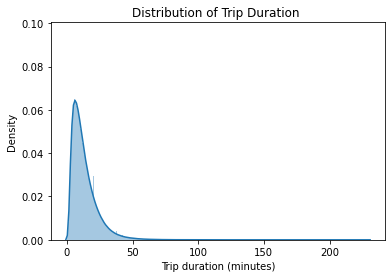

In [13]:
# Trip duration distribution

trip_duration_clean_df = clean_sdf.select('trip_duration_min').toPandas()
sns.distplot(trip_duration_clean_df['trip_duration_min'], bins = int(np.sqrt(len(trip_duration_clean_df))))
plt.title('Distribution of Trip Duration ')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Density')
plt.savefig('../plots/trip_duration_clean_distplot.png')
plt.show()

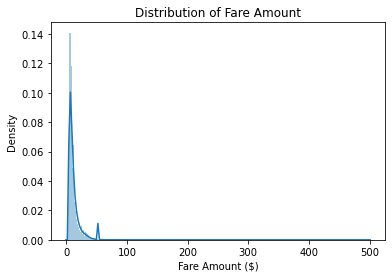

In [16]:
# Fare amount distribution
# we use rice binning for fare amount distribution
def rice(x):
    return int(2 * x ** (1/3))
    
fare_amount_clean_df = clean_sdf.select('fare_amount').toPandas()
sns.distplot(fare_amount_clean_df['fare_amount'], bins = rice(len(fare_amount_clean_df)))
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.savefig('../plots/fare_amount_clean_distplot.png')
plt.show()

In [7]:
# save clean data in parquet format
clean_sdf.write.format('parquet').save('../preprocessed_data/clean_yellow.parquet')

In [3]:
weather_df = pd.read_csv('../raw_data/nyc_weather_2018.csv',skiprows=[0])

# change datetime datatype
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# select desired date
weather_df = weather_df[((weather_df['DATE'] >= '2018-01-01') & (weather_df['DATE'] <= '2018-02-28')) | ((weather_df['DATE'] >= '2018-6-01') & (weather_df['DATE'] <= '2018-8-31')) | ((weather_df['DATE'] >= '2018-12-01') & (weather_df['DATE'] <= '2018-12-31'))]

# temperature is in Fahrenheit, change to Celsius
weather_df[['TMAX', 'TMIN']] = (weather_df[['TMAX', 'TMIN']] - 32) * 5/9

# average temperature is missing, compute using (TMAX + TMIN) / 2
weather_df['TAVG'] = (weather_df['TMAX'] + weather_df['TMIN']) / 2

# select desired columns
cols = ['DATE', 'TAVG', 'TMAX', 'TMIN','AWND','PRCP', 'SNOW', 'SNWD', 'WT01', 'WT02', 'WT03', 'WT08']
weather_df[['WT01', 'WT02', 'WT03', 'WT08']] = weather_df[['WT01', 'WT02', 'WT03', 'WT08']].fillna(0)
weather_df = weather_df[cols]

# rename columns
weather_df.columns = ['date', 'temp_ave', 'temp_max', 'temp_min', 'wind_ave', 'percip', 'snowfall', 'snowdepth', 'is_foggy', 'is_heavy_foggy', 'is_thunder', 'is_smoggy']

weather_df.head()

,date,temp_ave,temp_max,temp_min,wind_ave,percip,snowfall,snowdepth,is_foggy,is_heavy_foggy,is_thunder,is_smoggy
0,2018-01-01,-10.555556,-7.222222,-13.888889,7.83,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,-6.944444,-3.333333,-10.555556,8.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03,-5.000000,-1.111111,-8.888889,3.13,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04,-4.444444,-1.666667,-7.222222,12.53,0.76,9.8,1.2,1.0,1.0,0.0,1.0
4,2018-01-05,-10.000000,-7.222222,-12.777778,12.97,0.00,0.0,7.1,0.0,0.0,0.0,0.0


In [110]:
weather_df.to_csv('../preprocessed_data/nyc_weather_2018_clean.csv')